In [53]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['font.size'] = 16
plt.style.use('seaborn-v0_8')
!pwd    

/home/norekhov/_Pavel/phonons/U


In [17]:
with open('./md/dump.lammpstrj', 'r') as f:
        total_steps = sum(1 for line in f if "TIMESTEP" in line)
        print(f'Total steps: {total_steps}')

Total steps: 4001


In [39]:
from tqdm import tqdm 
import sys

def extract_coordinates(dump_file, target_timesteps=None, num_atoms=128000):
    """
    Извлекает координаты атомов в numpy массив формата (n_frames, n_atoms, 3)
    
    Параметры:
        dump_file: путь к файлу dump.lammpstrj
        target_timesteps: список нужных шагов (None = все шаги)
        num_atoms: количество атомов в системе
    """
    coords = []
    current_timestep = 0
    
    
    with open(dump_file, 'r') as f:
        
        pbar = tqdm(total=4001)
        while True:
            
            
            line = f.readline()
            if not line: break  # Конец файла
            
                
            if "TIMESTEP" in line:
                current_timestep = int(f.readline().strip())
                # Пропускаем заголовок
                for _ in range(7): f.readline()
                
                # Читаем координаты только для нужных шагов
                if target_timesteps is None or current_timestep in target_timesteps:
                    frame_coords = np.empty((num_atoms, 3), dtype=np.float32)
                    atom_idx = 0
                    
                    
                    while atom_idx < num_atoms:
                        parts = f.readline().split()
                        if len(parts) >= 5:  # Проверка формата: id type x y z ...
                            frame_coords[atom_idx] = [float(parts[2]), float(parts[3]), float(parts[4])]
                            atom_idx += 1
                    
                    
                            
                    
                    coords.append(frame_coords)
                    pbar.update(1)
                    
                else:
                    # Пропускаем ненужные шаги
                    for _ in range(num_atoms): f.readline()
                    
                
                
        pbar.close()
                    
            
    
    return np.stack(coords) if coords else np.empty((0, num_atoms, 3))

     
coords = extract_coordinates('./md/dump.lammpstrj', num_atoms=11664)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 4001/4001 [01:51<00:00, 36.03it/s]


In [40]:
np.save('data_11664at.npy', coords)

In [2]:
coords = np.load('data.npy')

In [41]:
num_atoms = len(coords[0])
num_atoms, coords.shape

(11664, (4001, 11664, 3))

In [62]:

e = np.array([1, 0, 0])
k = np.array([2 * np.pi / 3.52, 0, 0])
u = (((coords - coords[0]) * e).sum(axis=2)* np.cos((k * coords[0]).sum(axis=1))).sum(axis=1) / num_atoms
u.shape

(4001,)

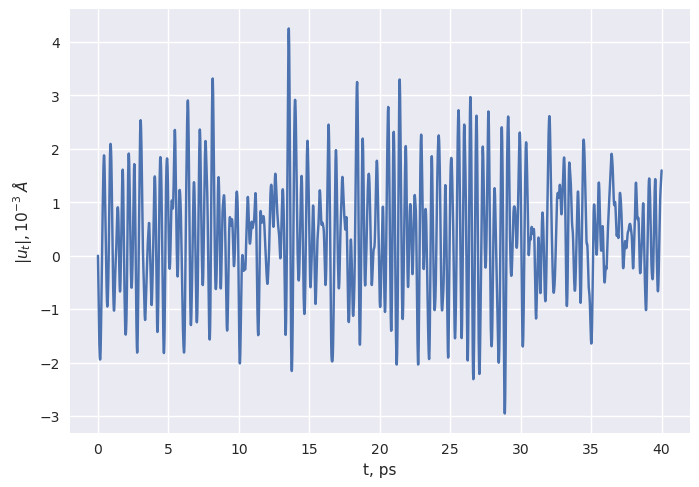

In [63]:
time = np.linspace(0, 40, 4001)
plt.xlabel('t, ps')
plt.ylabel('$|u_t|, 10^{-3} \\; \\AA$')
plt.plot(time, u * 1e3);

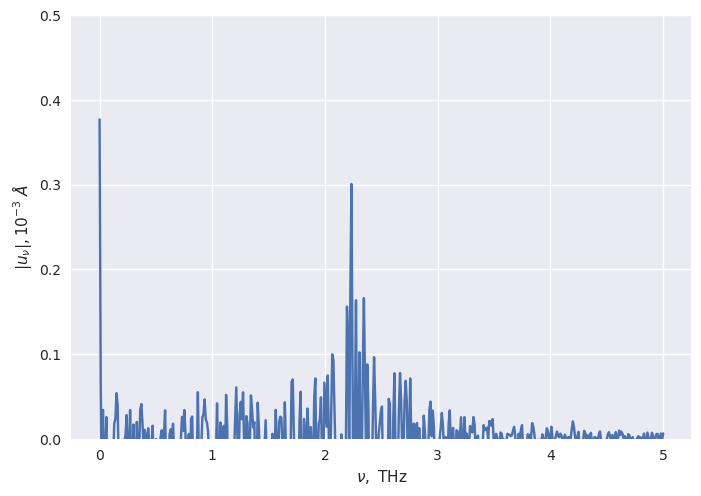

In [64]:
nu_grid = np.linspace(0, 5, 500)
N_t = len(time)

u_nu = 1 / N_t * (u * np.cos(2 * np.pi * nu_grid[:, np.newaxis] * time)).sum(axis=1)
plt.plot(nu_grid, u_nu * 1e3)
plt.ylim([0, 0.5])
plt.ylabel('$|u_\\nu|, 10^{-3} \\; \\AA$')
plt.xlabel('$\\nu, $ THz');
